# **0. 安装与调用**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/education/2020")

try:
    import shap
except ImportError:
    !pip install shap
    import shap

import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
from xgboost.sklearn import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **1. 读取数据**

In [3]:
time_0 = time.time()
df = pd.read_csv('./2020_data/data_u_code.csv', low_memory=False)
print('time of opening csv file: %.4f s' % (time.time() - time_0))

df = df[df['S5'] > 0]
df = df[df['S6'] > 0]

A, Y_matrix = df.iloc[:, list(range(9)) + list(range(42, 85))], df.iloc[:, range(85, 87)]
print(A.keys())
print(Y_matrix.keys())

time of opening csv file: 4.2921 s
Index(['INDEX', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'B1', 'B2',
       'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13',
       'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23',
       'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33',
       'B34', 'B35', 'B36', 'B37', 'B38', 'B39', 'B40', 'B41', 'B42', 'B43'],
      dtype='object')
Index(['S5', 'S6'], dtype='object')


# **2. 特征选择 (未修改)**

In [ ]:
Y = Y_matrix.iloc[:, 0] # S1

test_size = 0.1
A_train, A_test, Y_train, Y_test = train_test_split(A, Y, test_size=test_size)
X_train, X_test = A_train.iloc[:, 1:], A_test.iloc[:, 1:]

minor_std = (np.std(X_train, ddof=0) / np.abs(np.mean(X_train, axis=0))).sort_values()[:6].index    # 方差最小的6个变量
X_train = X_train.drop(minor_std, axis=1)
X_test = X_test.drop(minor_std, axis=1)

print(minor_std)
print(X_train.keys())

In [ ]:
for i in range(1):  # S1
    # XGBoost Model
    model = XGBRegressor(learning_rate=0.1,
                         n_estimators=600,
                         max_depth=12,
                         min_child_weight=1e-3,
                         gamma=0.01,
                         subsample=0.9,
                         scoring='r2',
                         objective ='reg:squarederror')
    
    model.fit(X_train, Y_train,
              verbose=False,
              early_stopping_rounds=5, 
              eval_set=[(X_test, Y_test)])

    Y_pred = model.predict(X_test)
    predictions = [round(value) for value in Y_pred]
    accuracy = accuracy_score(Y_test, predictions)
    print("Accuracy: %.4f%%" % (accuracy * 100.0))

    Y_pred_ = model.predict(X_train)
    predictions_ = [round(value) for value in Y_pred_]
    accuracy_ = accuracy_score(Y_train, predictions_)
    print("Accuracy: %.4f%%" % (accuracy_ * 100.0))

    plot_importance(model, title='Feature Importance: S%i' % (i + 1),
                    grid=False, max_num_features=10)
    plt.savefig('S%i.pdf' % (i + 1), bbox_inches = 'tight')
    plt.show()

    # SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer(X_train, interactions=False)

    # visualize the first prediction's explanation
    # (1) waterfall
    shap.plots.waterfall(shap_values[0], show=False)
    plt.savefig('Shap_waterfall%i.pdf' % (i + 1), bbox_inches = 'tight')
    plt.show()
    # (2) force
    shap.plots.force(shap_values[0], show=False, matplotlib=True)
    plt.savefig('Shap_force%i.pdf' % (i + 1), bbox_inches = 'tight')
    plt.show()

    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values, show=False)
    plt.savefig('Shap_beeswarm%i.pdf' % (i + 1), bbox_inches = 'tight')
    plt.show()

    # create a dependence scatter plot to show the effect of a single feature across the whole dataset
    shap.plots.scatter(shap_values[:, "A11"], color=shap_values, show=False)
    plt.savefig('Shap_scatter%i.pdf' % (i + 1), bbox_inches = 'tight')
    plt.show()

    # take the mean absolute value of the SHAP values for each feature
    shap.plots.bar(shap_values, show=False)
    plt.savefig('Shap_bar%i.pdf' % (i + 1), bbox_inches = 'tight')
    plt.show()

# **3. 训练XGBoost模型，并用SHAP解释模型**


## 模型调优 (未修改)


In [ ]:
Y = Y_matrix.iloc[:, 0] # S1

test_size = 0.1
A_train, A_test, Y_train, Y_test = train_test_split(A, Y, test_size=test_size)
X_train, X_test = A_train.iloc[:, 1:], A_test.iloc[:, 1:]

for i in range(1):
    print(i)
    model = XGBRegressor(learning_rate=0.1,
                         n_estimators=600,
                         max_depth=12,
                         min_child_weight=1e-3,
                         gamma=0.1,
                         subsample=0.9,
                         scoring='r2',
                         objective ='reg:squarederror')
    
    model.fit(X_train, Y_train,
              verbose=False,
              early_stopping_rounds=5, 
              eval_set=[(X_test, Y_test)])

    Y_pred, Y_pred_ = model.predict(X_test), model.predict(X_train)
    predictions, predictions_ = [round(value) for value in Y_pred], [round(value) for value in Y_pred_]
    accuracy, accuracy_ = accuracy_score(Y_test, predictions), accuracy_score(Y_train, predictions_)

    print('Loss_test: %.4f' % (np.sum(np.abs(Y_test - Y_pred)) / Y_test.shape[0] * 62.5))
    print('Loss_train: %.4f' % (np.sum(np.abs(Y_train - Y_pred_)) / Y_train.shape[0] * 62.5))
    print('Accuracy_test: %.4f%%' % (accuracy * 100.0))
    print('Accuracy_train: %.4f%%' % (accuracy_ * 100.0))

0
Loss_test: 35.2581
Loss_train: 24.4268
Accuracy_test: 54.2608%
Accuracy_train: 71.1219%


## 模型分析

Accuracy: 66.8406%


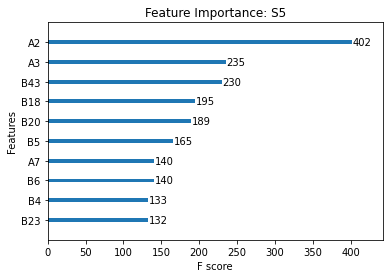

Student ID: 134249


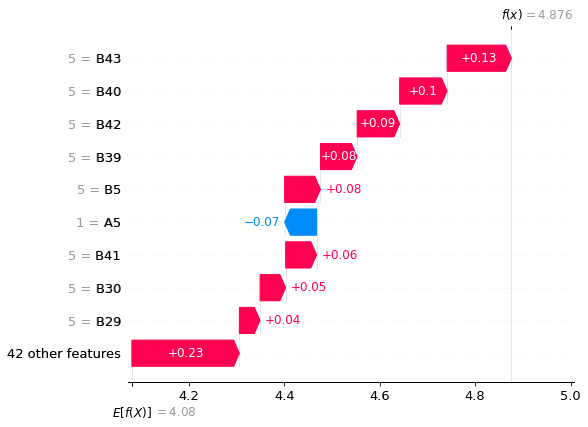

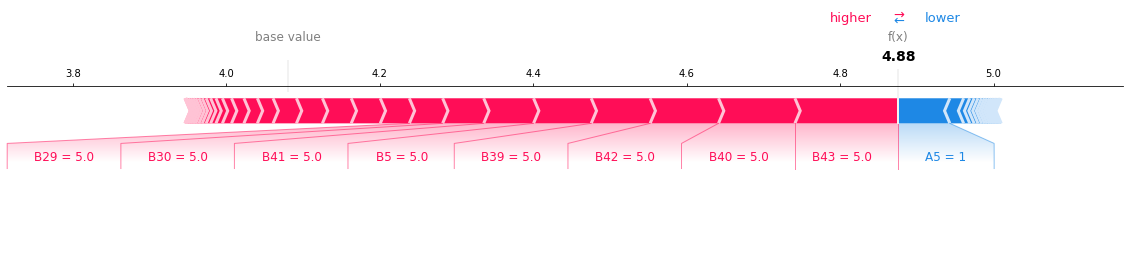

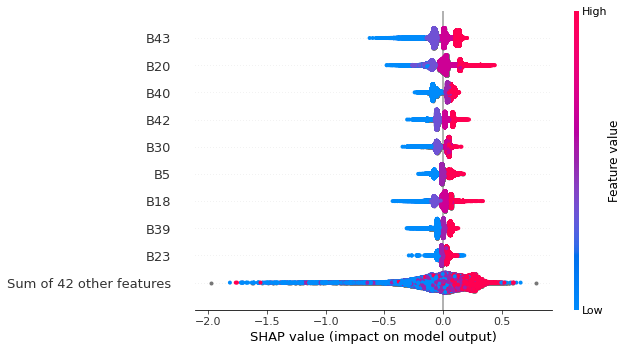

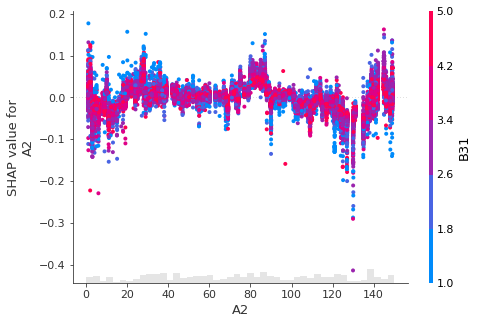

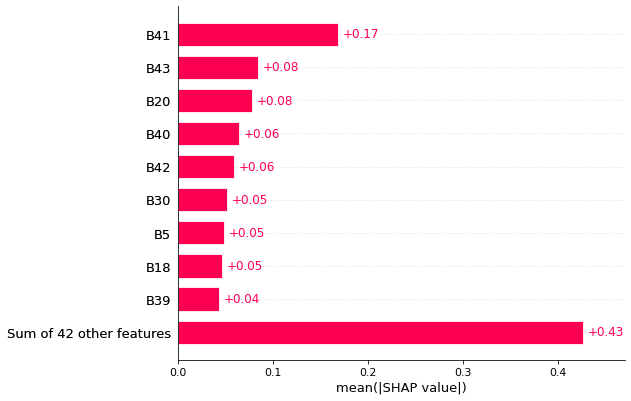

Accuracy: 69.8402%


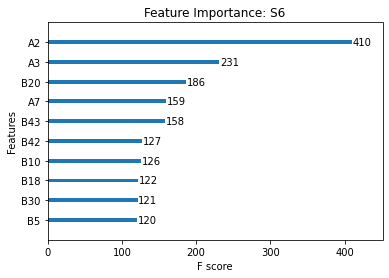

Student ID: 193350


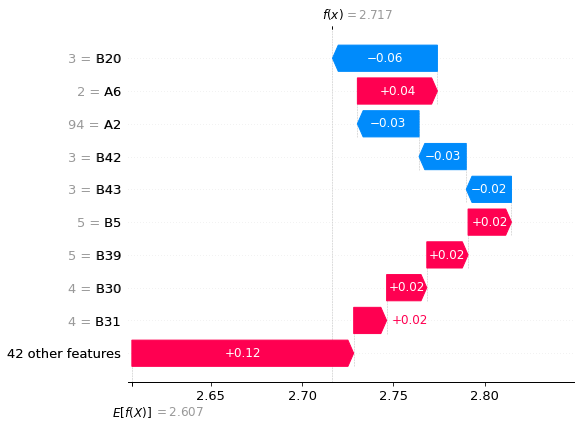

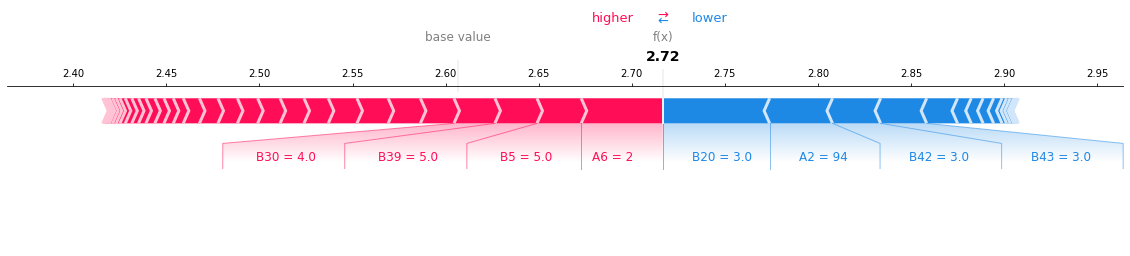

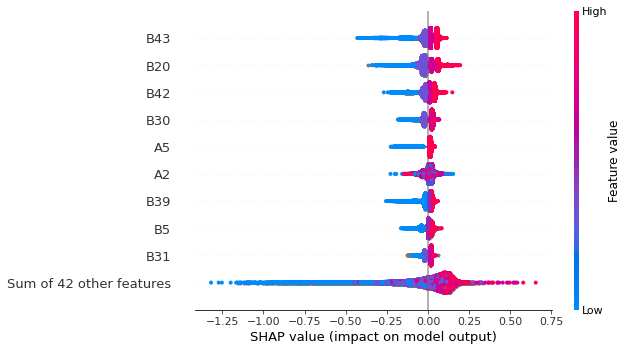

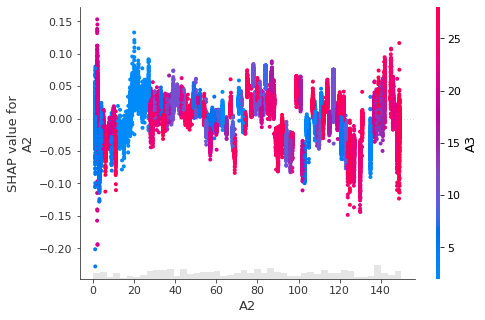

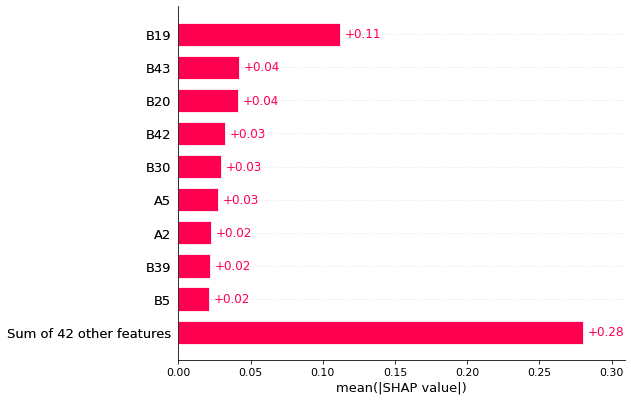

In [4]:
for i in range(2):  # S5~S6
    Y = Y_matrix.iloc[:, i]

    test_size = 0.1
    A_train, A_test, Y_train, Y_test = train_test_split(A, Y, test_size=test_size)
    X_train, X_test = A_train.iloc[:, 1:], A_test.iloc[:, 1:]

    # XGBoost Model
    model = XGBRegressor(learning_rate=0.1,
                         n_estimators=200,
                         max_depth=5,
                         min_child_weight=1e-3,
                         gamma=0.01,
                         subsample=0.9,
                         scoring='r2',
                         objective ='reg:squarederror')
    
    model.fit(X_train, Y_train,
              verbose=False,
              early_stopping_rounds=5, 
              eval_set=[(X_test, Y_test)])

    Y_pred = model.predict(X_test)
    predictions = [round(value) for value in Y_pred]
    accuracy = accuracy_score(Y_test, predictions)
    print("Accuracy: %.4f%%" % (accuracy * 100.0))

    plot_importance(model, title='Feature Importance: S%i' % (i + 5),
                    grid=False, max_num_features=10)
    plt.savefig('S%i.pdf' % (i + 5), bbox_inches = 'tight')
    plt.show()

    # SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer(X_train, interactions=False)

    # visualize the first prediction's explanation
    print('Student ID:', A_train.iloc[0, 0])
    # (1) waterfall
    shap.plots.waterfall(shap_values[0], show=False)
    plt.savefig('Shap_waterfall%i.pdf' % (i + 5), bbox_inches = 'tight')
    plt.show()
    # (2) force
    shap.plots.force(shap_values[0], show=False, matplotlib=True)
    plt.savefig('Shap_force%i.pdf' % (i + 5), bbox_inches = 'tight')
    plt.show()

    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values, show=False)
    plt.savefig('Shap_beeswarm%i.pdf' % (i + 5), bbox_inches = 'tight')
    plt.show()

    # create a dependence scatter plot to show the effect of a single feature across the whole dataset
    shap.plots.scatter(shap_values[:, "A2"], color=shap_values, show=False)
    plt.savefig('Shap_scatter%i.pdf' % (i + 5), bbox_inches = 'tight')
    plt.show()

    # take the mean absolute value of the SHAP values for each feature
    shap.plots.bar(shap_values, show=False)
    plt.savefig('Shap_bar%i.pdf' % (i + 5), bbox_inches = 'tight')
    plt.show()

    # Save Model
    model.save_model('u-01%i1.model' % i)

## 基于GPU计算的XGBoost模型 -- *E*[*f*(*X*)]有偏差  (未修改)

In [ ]:
Y = Y_matrix.iloc[:, 0]

test_size = 0.1
A_train, A_test, Y_train, Y_test = train_test_split(A, Y, test_size=test_size)
X_train, X_test = A_train.iloc[:, 1:], A_test.iloc[:, 1:]

# XGBoost Model
dmat = xgb.DMatrix(X_train, Y_train)
start = time.time()
model = xgb.train({"tree_method": "gpu_hist"}, dtrain=dmat, num_boost_round=10)
print("Model train time: %.2f s" % (time.time() - start))

# Make sure GPU prediction is enabled
model.set_param({"predictor": "gpu_predictor"})

# Predict and draw hist graph
predictions = model.predict(dmat)

# Compute SHAP values
start = time.time()
shap_values_xgboost = model.predict(dmat, pred_contribs=True)
print("SHAP time: %.2f s" % (time.time() - start))

# Compute SHAP interaction values
# start = time.time()
# shap_interactions = model.predict(dmat, pred_interactions=True)
# print("SHAP interactions time: %.2f s" % (time.time() - start))

In [ ]:
# Draw graphs
def plot_distribution(pred):
    plt.hist(pred, bins=40, density=True, color=sns.color_palette("coolwarm_r", 10)[0])
    plt.title("Prediction of Population Distribution")
    plt.xlabel("Overall Satisfaction Score", fontsize=13)
    plt.tight_layout()

def plot_feature_importance(feature_names, shap_values, max_display=10):
    # Get the mean absolute contribution for each feature
    aggregate = np.mean(np.abs(shap_values[:, 0:-1]), axis=0)
    # sort by magnitude
    z = [(x, y) for y, x in sorted(zip(aggregate, feature_names), reverse=True)][:max_display]
    z = list(zip(*z))
    
    plt.barh(z[0], z[1], color=sns.color_palette("coolwarm_r", max_display*4))
    for a, b in zip(np.arange(max_display), z[1]):
        if b <= 0.5:
            plt.text(b+0.05, a+0.25, '%.4f' % b, ha='center', va='bottom', fontsize=10)
        else:
            plt.text(b-0.05, a+0.25, '%.4f' % b, color='white', ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.xlabel('mean(|SHAP value|)', fontsize=13)
    plt.gca().invert_yaxis()

def plot_interactions(feature_names, shap_interactions, max_display=10):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append((feature_names[i] + "-" + feature_names[j], aggregate_interactions[i][j] * 2))
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))
    
    plt.barh(interaction_features[:max_display], interaction_values[:max_display],
             color=sns.color_palette("coolwarm_r", max_display*4))
    for a, b in zip(np.arange(max_display), interaction_values[:max_display]):
        if b <= 0.5:
            plt.text(b+0.05, a+0.25, '%.4f' % b, ha='center', va='bottom', fontsize=10)
        else:
            plt.text(b-0.05, a+0.25, '%.4f' % b, color='white', ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.xlabel('mean(|SHAP interaction value|)', fontsize=14)
    plt.gca().invert_yaxis()
    
    
plot_distribution(predictions)
plt.savefig('Distribution: S1.pdf', bbox_inches = 'tight')
plt.show()

plot_feature_importance(X_train.keys(), shap_values_xgboost)
plt.savefig('Feature_importance: S1.pdf', bbox_inches = 'tight')
plt.show()

shap.summary_plot(shap_values_xgboost[:,:-1], X_train, max_display=10, show=False)
plt.savefig('Feature_importance_summary: S1.pdf', bbox_inches = 'tight')
plt.show()

# plot_interactions(feature_names, shap_interactions)
# plt.savefig('Interaction: S1.pdf', bbox_inches = 'tight')
# plt.show()

In [ ]:
shap_values = shap.Explanation(shap_values_xgboost[:, :-1], 
                               shap_values_xgboost[:, -1], 
                               np.array(X_train))

shap.plots.waterfall(shap_values[0], show=True)

# **4. 分类分析 (未修改)**

## 4.1. 分学科门类 (A4)，预测总满意度 (S1)



In [ ]:
B = A   # B is a copy of A

In [ ]:
for i in range(1, 13):  # 12 classes
    print('Class:', i)
    A = B[B['A4'] == i]
    A = A.iloc[:, list(range(4)) + list(range(5, 29))]
    Y = Y_matrix.iloc[:, 0][B['A4'] == i]
    print('Number of Class %i Student: %i' % (i, Y.shape[0]))

    test_size = 0.1
    A_train, A_test, Y_train, Y_test = train_test_split(A, Y, test_size=test_size)
    X_train, X_test = A_train.iloc[:, 1:], A_test.iloc[:, 1:]

    model = XGBRegressor(learning_rate=0.1,
                         n_estimators=600,
                         max_depth=12,
                         min_child_weight=1e-3,
                         gamma=0.01,
                         subsample=0.9,
                         scoring='r2',
                         objective ='reg:squarederror')
    
    model.fit(X_train, Y_train,
              verbose=False,
              early_stopping_rounds=5, 
              eval_set=[(X_test, Y_test)])

    Y_pred = model.predict(X_test)
    predictions = [round(value) for value in Y_pred]
    accuracy = accuracy_score(Y_test, predictions)
    print("Accuracy: %.4f%%" % (accuracy * 100.0))

    plot_importance(model, title='Feature Importance: S1:Class%i' % i,
                    grid=False, max_num_features=10)
    plt.savefig('./graph/s1_undergraduate_2017_without_a13_group_by_a4/%i/S1:Class%i.pdf' % (i, i), bbox_inches = 'tight')
    plt.show()

    explainer = shap.Explainer(model)
    shap_values = explainer(X_train)

    # visualize the first prediction's explanation
    print(A_train.iloc[0, 0])
    # (1) waterfall
    shap.plots.waterfall(shap_values[0], show=False)
    plt.savefig('./graph/s1_undergraduate_2017_without_a13_group_by_a4/%i/Shap_waterfall:Class%i.pdf' % (i, i), bbox_inches = 'tight')
    plt.show()
    # (2) force
    shap.plots.force(shap_values[0], show=False, matplotlib=True)
    plt.savefig('./graph/s1_undergraduate_2017_without_a13_group_by_a4/%i/Shap_force:Class%i.pdf' % (i, i), bbox_inches = 'tight')
    plt.show()

    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values, show=False, max_display=15)
    plt.savefig('./graph/s1_undergraduate_2017_without_a13_group_by_a4/%i/Shap_beeswarm:Class%i.pdf' % (i, i), bbox_inches = 'tight')
    plt.show()

    # create a dependence scatter plot to show the effect of a single feature across the whole dataset
    shap.plots.scatter(shap_values[:, "A11"], color=shap_values, show=False)
    plt.savefig('./graph/s1_undergraduate_2017_without_a13_group_by_a4/%i/Shap_scatter:Class%i.pdf' % (i, i), bbox_inches = 'tight')
    plt.show()

    # take the mean absolute value of the SHAP values for each feature
    shap.plots.bar(shap_values, show=False, max_display=15)
    plt.savefig('./graph/s1_undergraduate_2017_without_a13_group_by_a4/%i/Shap_bar:Class%i.pdf' % (i, i), bbox_inches = 'tight')
    plt.show()

## 4.2. 分学校 (上海市)，预测总满意度 (S1)



In [ ]:
B = A   # B is a copy of A
seq = [[119621, 120054], [164758, 167189], [167190, 167983]]    # 3 college students' ID range

College or University: 0
Number of College or University 0 Student: 235
Accuracy: 29.1667%


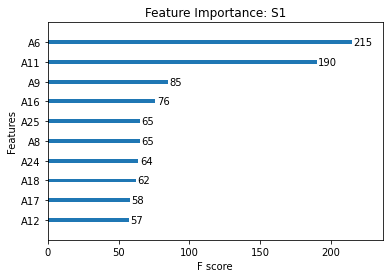

119776


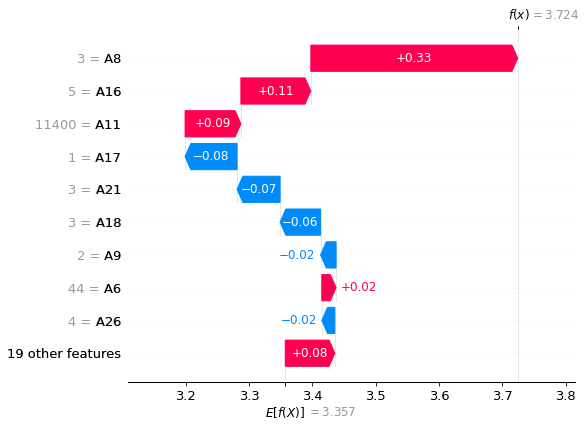

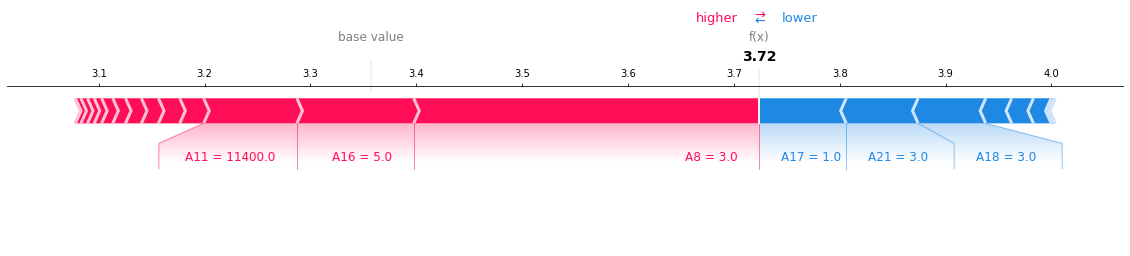

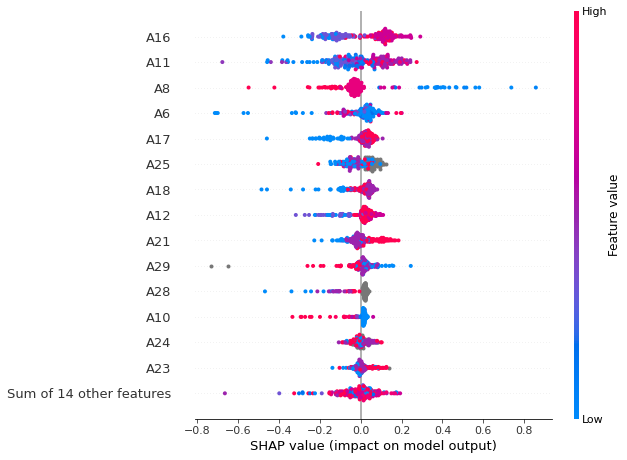

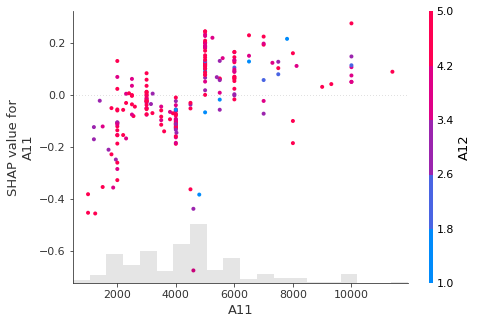

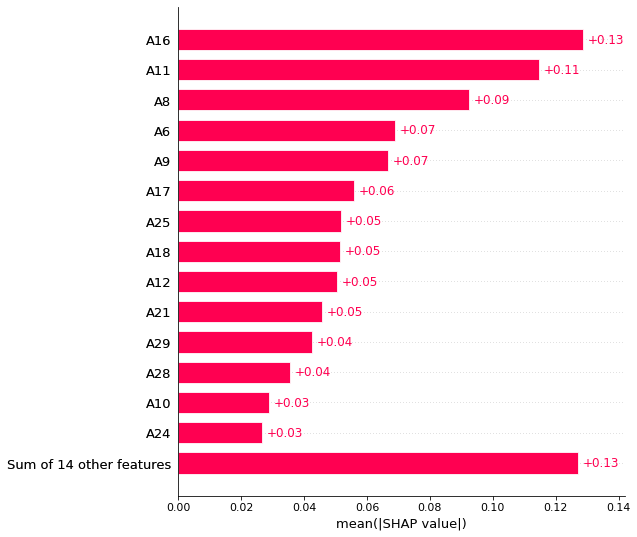

College or University: 1
Number of College or University 1 Student: 1423
Accuracy: 65.0350%


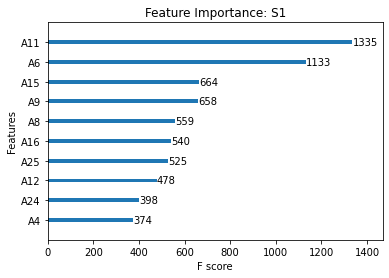

166508


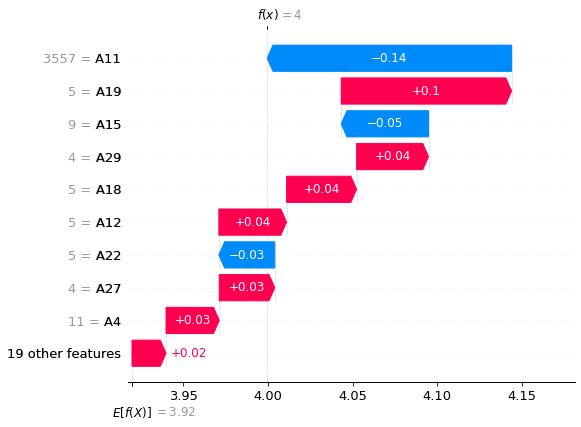

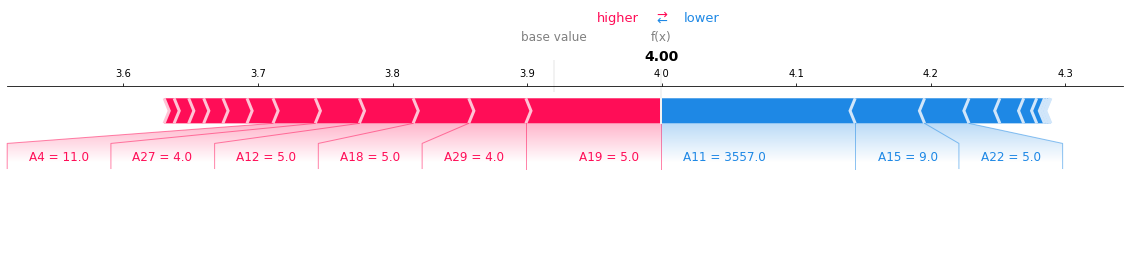

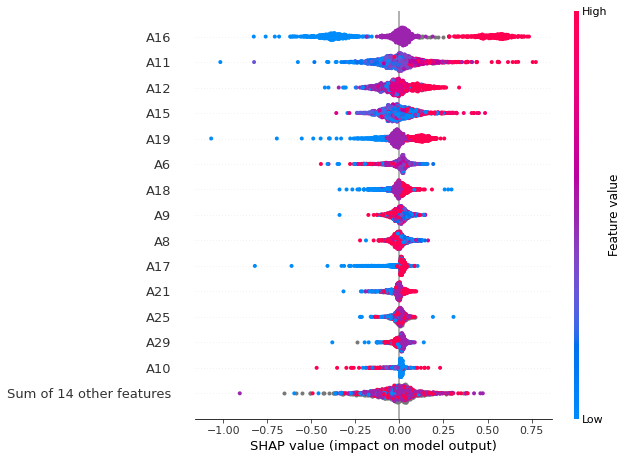

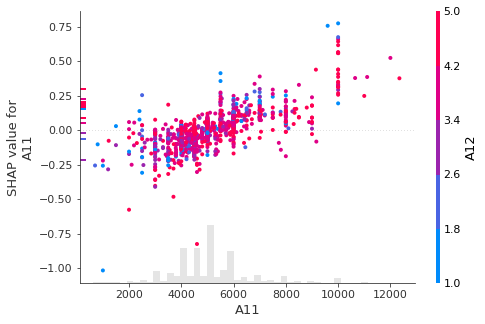

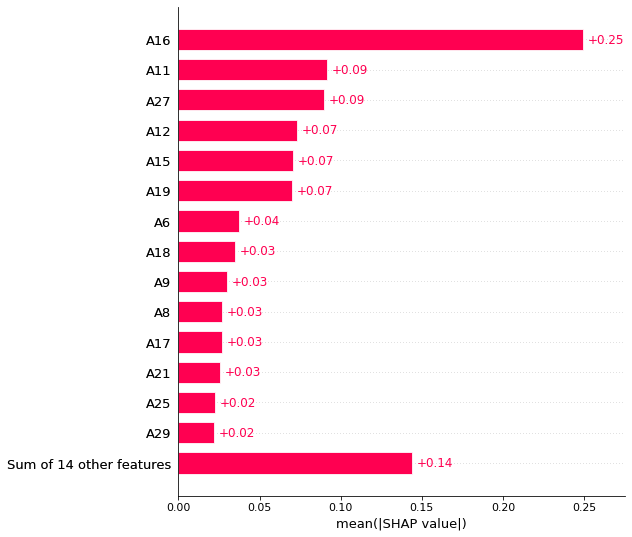

College or University: 2
Number of College or University 2 Student: 531
Accuracy: 51.8519%


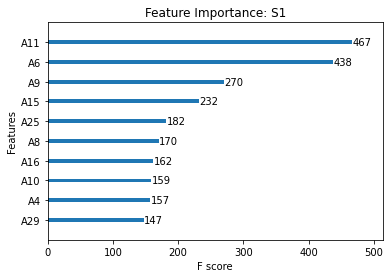

167950


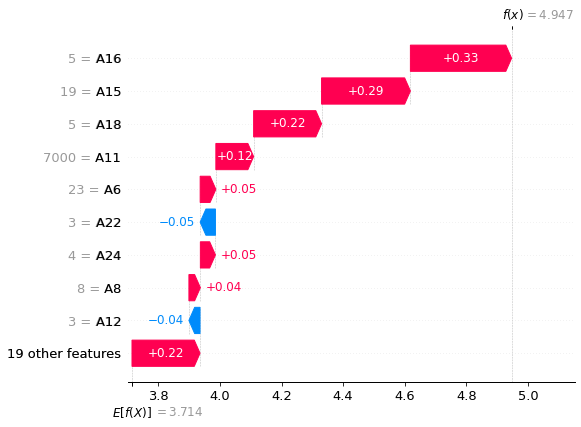

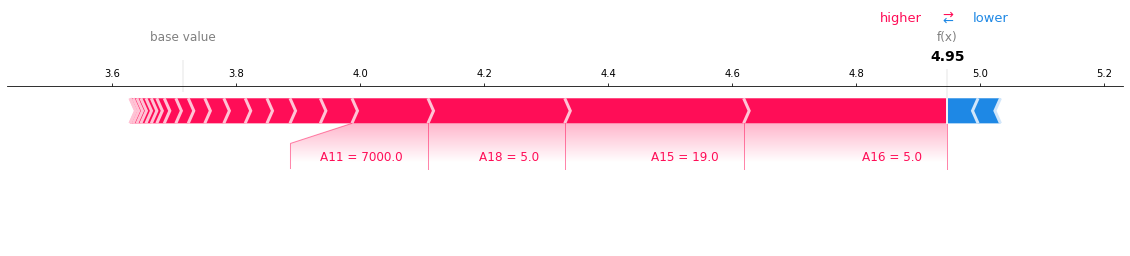

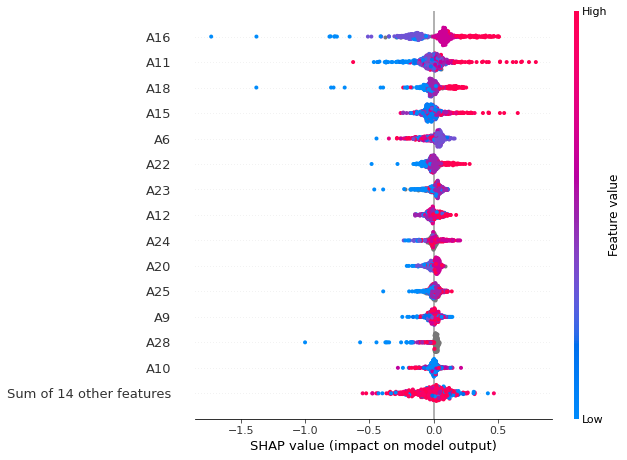

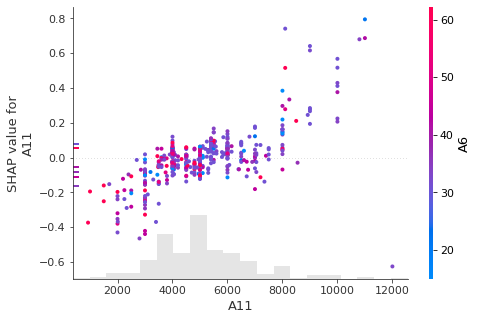

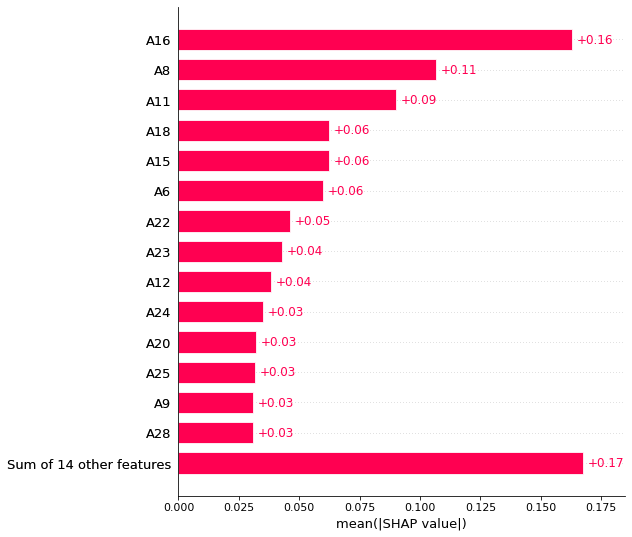

In [ ]:
for i in range(3):  # 12 classes
    print('College or University:', i)
    A = B[(seq[i][0] <= B['INDEX']) & (B['INDEX'] <= seq[i][1])]
    Y = Y_matrix.iloc[:, 0][(seq[i][0] <= B['INDEX']) & (B['INDEX'] <= seq[i][1])]
    print('Number of College or University %i Student: %i' % (i, Y.shape[0]))

    test_size = 0.1
    A_train, A_test, Y_train, Y_test = train_test_split(A, Y, test_size=test_size)
    X_train, X_test = A_train.iloc[:, 1:], A_test.iloc[:, 1:]

    model = XGBRegressor(learning_rate=0.1,
                         n_estimators=600,
                         max_depth=12,
                         min_child_weight=1e-3,
                         gamma=0.01,
                         subsample=0.9,
                         scoring='r2',
                         objective ='reg:squarederror')
    
    model.fit(X_train, Y_train,
              verbose=False,
              early_stopping_rounds=5, 
              eval_set=[(X_test, Y_test)])

    Y_pred = model.predict(X_test)
    predictions = [round(value) for value in Y_pred]
    accuracy = accuracy_score(Y_test, predictions)
    print("Accuracy: %.4f%%" % (accuracy * 100.0))

    plot_importance(model, title='Feature Importance: S1',
                    grid=False, max_num_features=10)
    plt.savefig('./graph/s1_undergraduate_2017_without_a13_Shanghai/%i/S1.pdf' % i, bbox_inches = 'tight')
    plt.show()

    explainer = shap.Explainer(model)
    shap_values = explainer(X_train)

    # visualize the first prediction's explanation
    print(A_train.iloc[0, 0])
    # (1) waterfall
    shap.plots.waterfall(shap_values[0], show=False)
    plt.savefig('./graph/s1_undergraduate_2017_without_a13_Shanghai/%i/Shap_waterfall.pdf' % i, bbox_inches = 'tight')
    plt.show()
    # (2) force
    shap.plots.force(shap_values[0], show=False, matplotlib=True)
    plt.savefig('./graph/s1_undergraduate_2017_without_a13_Shanghai/%i/Shap_force.pdf' % i, bbox_inches = 'tight')
    plt.show()

    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values, show=False, max_display=15)
    plt.savefig('./graph/s1_undergraduate_2017_without_a13_Shanghai/%i/Shap_beeswarm.pdf' % i, bbox_inches = 'tight')
    plt.show()

    # create a dependence scatter plot to show the effect of a single feature across the whole dataset
    shap.plots.scatter(shap_values[:, "A11"], color=shap_values, show=False)
    plt.savefig('./graph/s1_undergraduate_2017_without_a13_Shanghai/%i/Shap_scatter.pdf' % i, bbox_inches = 'tight')
    plt.show()

    # take the mean absolute value of the SHAP values for each feature
    shap.plots.bar(shap_values, show=False, max_display=15)
    plt.savefig('./graph/s1_undergraduate_2017_without_a13_Shanghai/%i/Shap_bar.pdf' % i, bbox_inches = 'tight')
    plt.show()